In [20]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, os
import random
import seaborn as sns

import astropy
from astropy.io import fits

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorboard.plugins.hparams import api as hp

from tensorflow.keras import activations
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from scipy.stats import bernoulli

from matplotlib.ticker import FormatStrFormatter

In [2]:
np.random.seed(0)
scaler = StandardScaler()

### Conjunto de datos: 

In [3]:
with fits.open('https://github.com/igomezv/cosmo_tools/blob/main/COB_22/Viviana_Acquaviva/DEEP2_uniq_Terapix_Subaru_v1.fits?raw=true') as data:
    df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder()) #see https://numpy.org/devdocs/user/basics.byteswapping.html#changing-byte-ordering

In [4]:
df.head()

,objno_deep2,ra_deep2,dec_deep2,magb,magr,magi,pgal,sfd_ebv,class,subclass,...,ra_subaru,dec_subaru,y,yerr,y_apercor,yerr_aper,yerr_apercor,y(sexflag),y_radius_arcsec,subaru_source
0,11001673,213.868704,51.956445,23.487745,23.143082,22.582092,1.000000,0.010943,b'',b'',...,213.868626,51.956443,21.869627,0.060918,21.926356,0.041955,0.141778,3.0,0.656514,1
1,11001699,213.810471,51.942316,22.067692,20.034674,19.545080,3.000000,0.011014,b'GALAXY',b'',...,213.810455,51.942321,18.757229,0.005813,18.811085,0.004386,0.050987,3.0,0.744269,1
2,11001770,213.848431,51.948876,24.144438,24.103180,24.020006,3.000000,0.010856,b'GALAXY',b'',...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
3,11001800,213.831758,51.952548,25.336836,23.508480,23.081087,0.509809,0.010823,b'GALAXY',b'',...,213.831766,51.952544,22.404269,0.088970,22.535600,0.053497,0.094733,0.0,0.455820,1
4,11001860,213.832550,51.954174,24.382738,23.401484,22.572845,3.000000,0.010827,b'GALAXY',b'',...,213.832574,51.954175,22.242717,0.070760,22.100980,0.033256,0.073067,0.0,0.442022,1


In [5]:
features = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']]
features.head()

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
0,23.543491,23.430495,23.100311,22.768970,22.223810,21.926356
1,30.848978,28.989668,19.027422,99.000000,99.000000,18.811085
2,24.324670,24.273606,24.150319,23.446252,23.574236,-99.000000
3,99.000000,24.804309,23.636544,23.009222,22.689591,22.535600
4,24.362068,24.136913,23.490342,22.777181,22.319676,22.100980


In [6]:
target = df['zhelio']
target.head()

0    1.115261
1    0.290608
2    0.605744
3    1.306796
4    0.957669
Name: zhelio, dtype: float32

In [7]:
mags = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor','zquality','cfhtls_source']]

In [8]:
mags = mags[mags['zquality'] >= 3]

mags.shape

(16857, 8)

In [9]:
mags.shape

(16857, 8)

In [10]:
mags = mags[mags > -10].dropna()
mags = mags[mags < 90].dropna()

In [11]:
mags = mags[mags['cfhtls_source'] == 0]

In [12]:
mags.shape

(6307, 8)

In [13]:
params = ['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']
features_ext = mags.copy()
for i, name1 in enumerate(params):
    for j, name2 in enumerate(params):
        if i >=j: continue #build only one pair, avoid zero colors
        features_ext[name1 + '-' + name2] = features[name1] - features[name2]

In [14]:
features_ext.head()

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor,zquality,cfhtls_source,u_apercor-g_apercor,u_apercor-r_apercor,...,g_apercor-r_apercor,g_apercor-i_apercor,g_apercor-z_apercor,g_apercor-y_apercor,r_apercor-i_apercor,r_apercor-z_apercor,r_apercor-y_apercor,i_apercor-z_apercor,i_apercor-y_apercor,z_apercor-y_apercor
1251,24.244393,23.979583,23.522136,22.911041,22.525773,22.329098,4,0.0,0.264811,0.722258,...,0.457447,1.068542,1.453810,1.650485,0.611094,0.996362,1.193037,0.385268,0.581943,0.196675
1253,24.489104,23.916151,22.923651,21.873752,21.306495,21.251440,4,0.0,0.572953,1.565453,...,0.992500,2.042399,2.609656,2.664711,1.049899,1.617157,1.672212,0.567258,0.622312,0.055055
1261,24.873959,22.973893,21.465850,20.788420,20.462283,20.413696,3,0.0,1.900066,3.408108,...,1.508042,2.185473,2.511610,2.560196,0.677430,1.003568,1.052154,0.326138,0.374724,0.048586
1271,24.529042,24.338631,23.891189,23.206102,22.989344,23.112382,4,0.0,0.190411,0.637853,...,0.447442,1.132529,1.349287,1.226250,0.685087,0.901845,0.778808,0.216758,0.093721,-0.123037
1272,23.641180,23.387447,22.975301,22.235199,21.809658,21.559483,4,0.0,0.253733,0.665879,...,0.412146,1.152248,1.577789,1.827964,0.740102,1.165643,1.415818,0.425541,0.675717,0.250175


In [15]:
target = target[features_ext.index]

In [16]:
features_paper = features_ext[['u_apercor-g_apercor','g_apercor-r_apercor', \
            'r_apercor-i_apercor','i_apercor-z_apercor','z_apercor-y_apercor','i_apercor']]

In [17]:
# Produces test split.
X_train, X_val, Y_train, Y_val = train_test_split(features_paper, target, test_size=0.2)

In [18]:
# loss -> val_loss
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=200,
                                   restore_best_weights=True, verbose=False)
                                   ]

n_cols = 1
epochs=200

In [21]:
model1 = load_model("models/model_zphoto.h5")
model_gena = load_model("models/model_genetic_zphoto.h5")
model_genb = load_model("models/model_genetic_zphoto2.h5")

2022-12-22 01:07:18.132151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 01:07:18.132487: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-22 01:07:18.132581: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-22 01:07:18.132657: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-22 01:07:18.132732: W tensorflow/c

In [22]:
zpred_grid = model1.predict(X_val)

40/40 [==============================] - 0s 785us/step


In [24]:
zpred_genetic = model_gena.predict(X_val)

40/40 [==============================] - 0s 803us/step


In [25]:
zpred_genetic2 = model_genb.predict(X_val)

40/40 [==============================] - 0s 701us/step


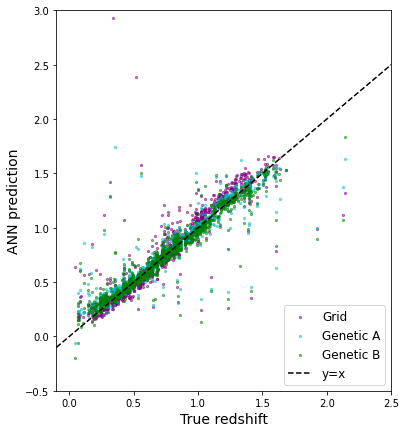

In [46]:
plt.figure(figsize=(6,7))
plt.scatter(Y_val, zpred_grid, label='Grid', color='purple', alpha=0.5, marker = 'o', s=5)
plt.scatter(Y_val, zpred_genetic, label='Genetic A', color='c', alpha=0.5, marker = 'o', s=5)
plt.scatter(Y_val, zpred_genetic2, label='Genetic B', color='g', alpha=0.5, marker = 'o', s=5)
x = np.linspace(-0.1,4.5,100)
plt.plot(x, x, linestyle='dashed', c='black', label='y=x')
plt.xlabel("True redshift", fontsize=14)
plt.ylabel("ANN prediction", fontsize=14)
plt.xlim(-0.1, 2.5)
plt.ylim(-0.5,3)
plt.legend(fontsize=12)
plt.savefig("photoz.png", dpi=100)

In [33]:
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error

In [28]:
y1 = model1.predict(X_val)
ya = model_gena.predict(X_val)
yb = model_genb.predict(X_val)

40/40 [==============================] - 0s 669us/step


In [29]:
y_test = Y_val.values.reshape(-1,1)
np.shape(y_test), np.shape(y1)

((1262, 1), (1262, 1))

In [34]:
r1 = r2_score(y1, y_test)
r2 = r2_score(ya, y_test)
r3 = r2_score(yb, y_test)
r1, r2, r3

(0.7940160971237055, 0.8608075478338171, 0.8192290242661961)

In [35]:
v1 = explained_variance_score(y1, y_test)
v2 = explained_variance_score(ya, y_test)
v3 = explained_variance_score(yb, y_test)
v1, v2, v3

(0.7969561815261841, 0.8649717569351196, 0.8193362355232239)

In [36]:
mae1 = mean_absolute_error(y1, y_test)
mae2 = mean_absolute_error(ya, y_test)
mae3 = mean_absolute_error(yb, y_test)
mae1, mae2, mae3

(0.074807, 0.058287155, 0.057133816)